# Physical Risk Propagation Model — EU-27 SAM (Scenario Runs)

This notebook is the *single entry point* to:
- load the latest EU-27 SAM (long format) from Databricks
- extract IO-style blocks (`Z`, `FD`, `X`, `A`, `globsec_of`, `node_labels`)
- run the **physical-risk propagation** model under supply/demand shocks
- inspect and visualize impacts (country / sector), including a Europe choropleth


## 0) Environment and imports

**Prerequisites**
- You are running on a Databricks cluster or a local environment with a working Spark session (`spark`) connected to the Databricks metastore.
- The project `src/` folder is importable (we add it to `sys.path` below).

If you are running locally, ensure Databricks Connect is configured and `spark` is available.


In [1]:
import os
import sys

import numpy as np
import pandas as pd

# --- Make project imports work from the repo root
PROJECT_ROOT = os.path.abspath(os.getcwd())
SRC_DIR = os.path.join(PROJECT_ROOT, "src")
if SRC_DIR not in sys.path:
    sys.path.insert(0, SRC_DIR)

from data_io.eurostat_sam import load_sam_latest_year, extract_model_inputs_from_sam
from src.data_io.sector_decoder import build_sector_decoder
from src.io_climate.postprocess import postprocess_results
from io_climate.model import IOClimateModel


## 1) Load SAM and extract model inputs

The SAM is expected in **long format** and must include:
- `geo_ava`, `ind_ava` (producer country/account)
- `geo_use`, `ind_use` (user country/account)
- `value` (flow)
- `share` (precomputed coefficient: cell value / total output of user column)

`extract_model_inputs_from_sam(...)` builds:
- `Z` (n×n) intermediate flows among production sectors (`P_*`)
- `FD` (n,) final demand from accounts `[HH, GOV, CF, WRL_REST]`
- `X` (n,) gross output = `row_sum(Z) + FD`
- `A` (n×n) technical coefficients (from `share` for the `P_* → P_*` block)
- `globsec_of` (n,) maps each node to its global sector id (same `P_*` across countries)
- `node_labels` list of `"CC::P_..."` strings, consistent with matrix ordering


In [2]:
# Load latest year from Databricks table
sam_df, latest_year = load_sam_latest_year(spark)
print("SAM year:", latest_year)
print("Rows:", sam_df.count())

# Extract model inputs (numpy arrays + labels)
Z, FD, X, A, globsec_of, node_labels = extract_model_inputs_from_sam(sam_df)

n = len(node_labels)
print("n nodes:", n)
print("Z shape:", Z.shape, "A shape:", A.shape, "FD shape:", FD.shape, "X shape:", X.shape)


SAM year: 2022
Rows: 2040159
n nodes: 1695
Z shape: (1695, 1695) A shape: (1695, 1695) FD shape: (1695,) X shape: (1695,)


## 1b) Sector name mapping table

If available, you can load a sector mapping/decoder table to attach human-readable sector names to results. 
At this stage, the model uses **NACE codes** from `node_labels` (e.g. `IT::P_D35`). The mapping is **not** required to run the model.


In [3]:
sectors_in_sam = sorted({lbl.split("::")[1] for lbl in node_labels})
sector_decoder = build_sector_decoder(
    spark,
    sectors_in_sam=sectors_in_sam,
)
print("Sectors in SAM:", len(sectors_in_sam))
display(sector_decoder)

Sectors in SAM: 63


{'P_C10-12': 'Manufacture of food products; beverages and tobacco products',
 'P_K65': 'Insurance, reinsurance and pension funding, except compulsory social security',
 'P_D35': 'Electricity, gas, steam and air conditioning supply',
 'P_R90-92': 'Creative, arts and entertainment activities; libraries, archives, museums and other cultural activities; gambling and betting activities',
 'P_J58': 'Publishing activities',
 'P_M69_70': 'Legal and accounting activities; activities of head offices; management consultancy activities',
 'P_C29': 'Manufacture of motor vehicles, trailers and semi-trailers',
 'P_M71': 'Architectural and engineering activities; technical testing and analysis',
 'P_O84': 'Public administration and defence; compulsory social security',
 'P_C19': 'Manufacture of coke and refined petroleum products',
 'P_S94': 'Activities of membership organisations',
 'P_J62_63': 'Computer programming, consultancy, and information service activities',
 'P_A03': 'Fishing and aquaculture

### 1.1 Quick sanity checks

These checks catch the most common ingestion issues (ordering mismatches, missing blocks, negative values).


In [4]:
assert Z.shape == (n, n)
assert A.shape == (n, n)
assert FD.shape == (n,)
assert X.shape == (n,)
assert len(globsec_of) == n

print("Min values — Z:", float(Z.min()), "A:", float(A.min()), "FD:", float(FD.min()), "X:", float(X.min()))
print("Totals — sum(Z):", float(Z.sum()), "sum(FD):", float(FD.sum()), "sum(X):", float(X.sum()))

# Accounting identity at baseline (row accounting)
row_gap = np.linalg.norm(X - (FD + Z.sum(axis=1)), ord=1)
print("Baseline accounting gap (L1):", float(row_gap))




Min values — Z: 0.0 A: 0.0 FD: -0.040412221578703625 X: 1.2000000000907844
Totals — sum(Z): 13941501.474966172 sum(FD): 14831340.773248244 sum(X): 28772842.248214405
Baseline accounting gap (L1): 0.0


## 2) Instantiate the model

`IOClimateModel` stores the **baseline economy** internally (`Z0`, `A0`, `L0`, `X0`, `FD0`), and enforces a fixed **global-technology** matrix `A_G` derived from baseline global-sector aggregation.

For scenario diagnostics, keep a copy of baseline output **outside** the model, to avoid any ambiguity.


In [5]:
model = IOClimateModel(
    Z=Z,
    FD=FD,
    X=X,
    globsec_of=globsec_of,
    A=A,
    node_labels=node_labels,
)

# Baseline copies for diagnostics
X_baseline = X.copy()
FD_baseline = FD.copy()

print("Model ready.")
print("Baseline total output:", float(X_baseline.sum()))
print("Baseline total final demand:", float(FD_baseline.sum()))
print("Global sectors:", model.S_glob)


Model ready.
Baseline total output: 28772842.248214405
Baseline total final demand: 14831340.773248244
Global sectors: 63


## 3) Define and run a scenario

You can define shocks either:
- by providing `sd` and `sp` vectors directly, or
- by specifying `(country_codes, sector_codes, supply_shock_pct, demand_shock_pct)`.

This notebook uses **scenario mode** for convenience.

Notes:
- Supply shock reduces capacity: `X_cap = X0 * (1 - sp)`
- Demand shock reduces initial final demand: `FD_post = FD0 * (1 - sd)`
- Outer iteration reduces demand *further* only where implied demand is lower than `FD_post` (elementwise monotone update).


In [ ]:
scenario = dict(
    # Supply shock target: Portugal energy/utilities
    supply_country_codes=["PT"],      # Portugal
    supply_sector_codes=["P_D35"],        # Electricity, gas, steam
    supply_shock_pct=10.0,

    # Demand shock target: Italy, several service sectors
    demand_country_codes=["IT"],            # Italy
    demand_sector_codes=["P_H49", "P_J61", "P_M69_70"],  # transport, telecom, professional services
    demand_shock_pct=2.5,

    gamma=0.8,
    max_iter=100,
    tol=1e-3,
    return_history=True,
)

results = model.run(**scenario)

print("Converged:", results["converged"])
print("Iterations:", results["iterations"])


Converged: True
Iterations: 5


## 4) Build node-level impact table

We compute output losses at node level and aggregate by:
- country
- sector


In [37]:
# Postprocess run outputs into standardized tables and KPIs
pp = postprocess_results(
    node_labels=node_labels,
    Z0=Z,
    X0=X_baseline,
    Z1=results["Z_final"],
    X1=results["X_supply_final"],
    FD_post=results.get("FD_post_final"),
    sector_name_map=sector_decoder,   # optional; comment out if not available
    linkage_metric="A",              # structural change via technical coefficients
    top_k_links=25,
)

df_nodes = pp.df_nodes
df_country = pp.df_country
df_sector = pp.df_sector

# Structural change (top linkages)
df_links_weakened = pp.df_links_weakened
df_links_strengthened = pp.df_links_strengthened

pp.meta


{'X_baseline_total': 28772842.248214405,
 'X_final_total': 27430260.676529124,
 'X_loss_abs_total': 1342581.5716852807,
 'X_loss_pct_total': 4.6661416348904465,
 'VA_baseline_total': 14831340.77324824,
 'VA_final_total': 14141342.2767293,
 'VA_loss_abs_total': 689998.4965189397,
 'VA_loss_pct_total': 4.652300200420935,
 'FD_post_total': 14141347.60886505}

### 4.1 Post-processed impacts (output, value added, and structural change)

The post-processing step produces standardized tables:

- `df_nodes`: node-level impacts (country–sector)
- `df_country`: country aggregates
- `df_sector`: sector aggregates (decoded names if available)
- `df_links_weakened` / `df_links_strengthened`: largest linkage changes (ΔA by default)

Units:
- Output and value added are in the same unit as the SAM flows (typically EUR).


In [38]:
# Quick views (tables)
df_country.head(10), df_sector.head(10)


(   country    X_baseline       X_final       loss_abs   VA_baseline  \
 5       DE  6.905942e+06  6.613765e+06  292177.271418  3.557843e+06   
 11      FR  4.681131e+06  4.471057e+06  210074.524115  2.380209e+06   
 15      IT  3.751974e+06  3.574564e+06  177410.175692  1.827599e+06   
 9       ES  2.442810e+06  2.332858e+06  109952.081743  1.324897e+06   
 20      NL  1.738425e+06  1.662324e+06   76100.438699  9.607036e+05   
 21      PL  1.310212e+06  1.252268e+06   57944.290173  6.443907e+05   
 1       BE  1.099704e+06  1.051798e+06   47906.118309  5.446183e+05   
 0       AT  8.110387e+05  7.655666e+05   45472.051431  4.027755e+05   
 24      SE  9.215626e+05  8.831214e+05   38441.218345  4.986103e+05   
 22      PT  4.367816e+05  4.006569e+05   36124.651877  2.141063e+05   
 
         VA_final    VA_loss_abs  loss_pct  VA_loss_pct  
 5   3.408834e+06  149008.576532  4.230810     4.188172  
 11  2.272394e+06  107815.416960  4.487687     4.529661  
 15  1.742362e+06   85236.872264

## 5) Visualizations

This section provides:
- choropleth map (Europe) of absolute or percent losses by country
- bar charts of absolute losses by country and sector

If `matplotlib` is not installed in your environment, the bar charts will fall back to tables.


In [39]:
# --- ISO2 -> ISO3 conversion for Plotly (Plotly choropleth requires ISO-3)
try:
    import pycountry

    def iso2_to_iso3(iso2: str):
        c = pycountry.countries.get(alpha_2=iso2)
        return c.alpha_3 if c else None

    df_country["iso3"] = df_country["country"].apply(iso2_to_iso3)

    unmapped = df_country[df_country["iso3"].isna()]
    if len(unmapped) > 0:
        print("Warning: unmapped ISO-2 codes:", unmapped["country"].tolist())

except ModuleNotFoundError:
    df_country["iso3"] = None
    print("pycountry not installed; choropleth map will not work until you install it: pip install pycountry")


In [40]:
# --- Choropleth (Europe scope), absolute losses
import plotly.express as px

df_map = df_country.dropna(subset=["iso3"]).copy()

fig = px.choropleth(
    df_map,
    locations="iso3",
    locationmode="ISO-3",
    color="loss_abs",
    hover_name="country",
    hover_data={"loss_abs": True, "loss_pct": True, "iso3": False, "country": False},
    color_continuous_scale="Reds",
    title="Total Output Loss by Country (absolute)",
)

fig.update_layout(
    geo=dict(showframe=False, showcoastlines=True),
    margin=dict(l=0, r=0, t=40, b=0),
)

fig.show()


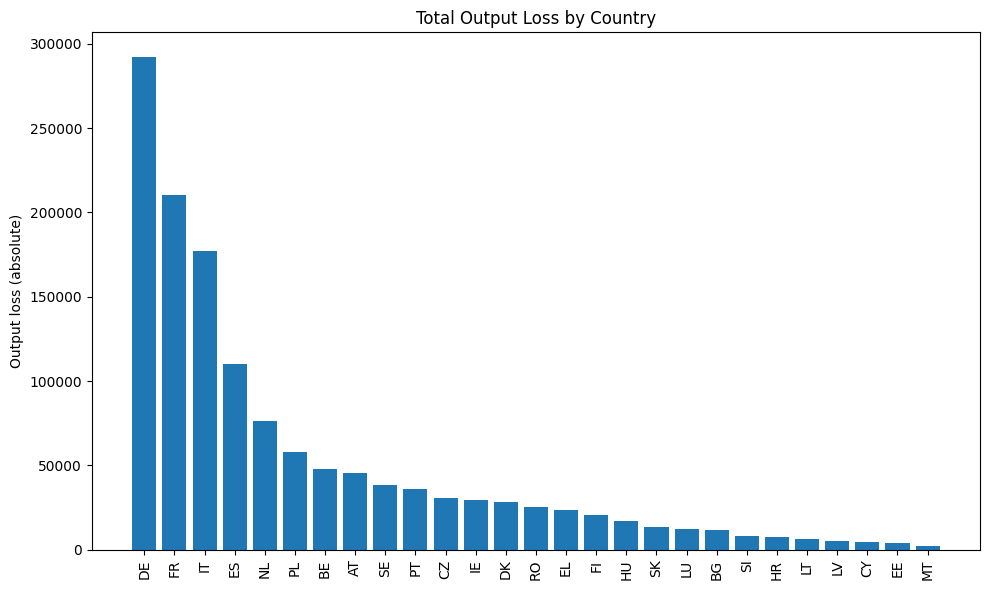

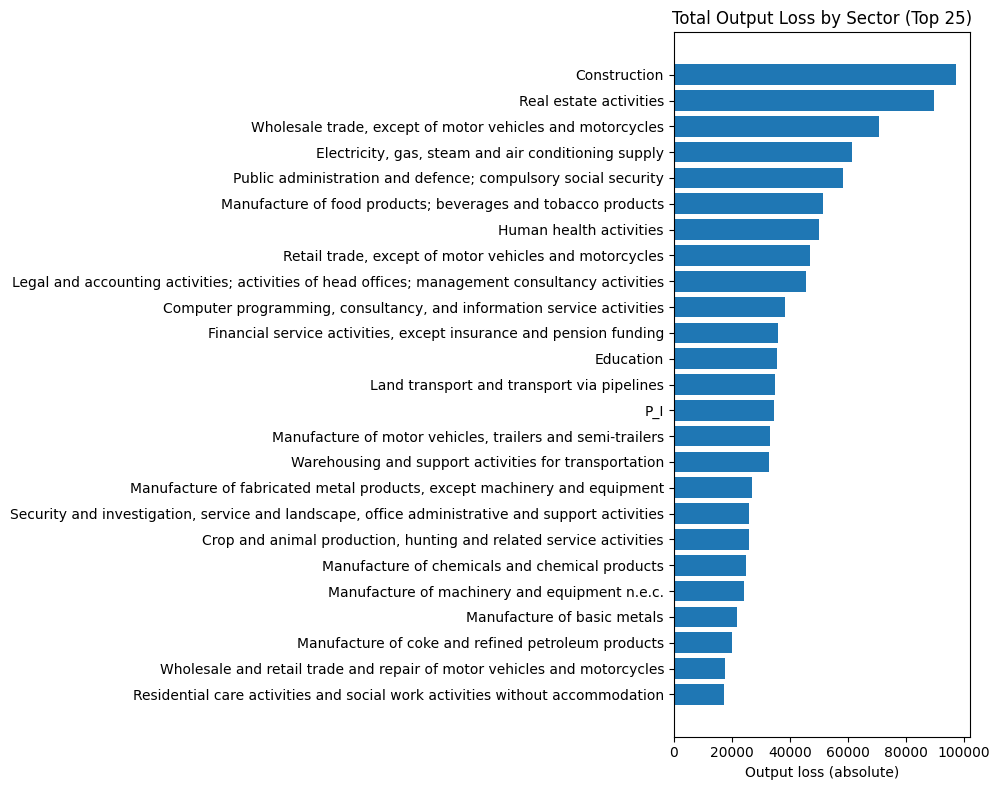

In [41]:
# --- Bar charts (absolute losses) with safe fallback if matplotlib is missing
try:
    import matplotlib.pyplot as plt

    # Country bar
    plt.figure(figsize=(10, 6))
    plt.bar(df_country["country"], df_country["loss_abs"])
    plt.xticks(rotation=90)
    plt.ylabel("Output loss (absolute)")
    plt.title("Total Output Loss by Country")
    plt.tight_layout()
    plt.show()

    # Sector bar (top 25)
    top_sector = df_sector.head(25).sort_values("loss_abs", ascending=True)
    plt.figure(figsize=(10, 8))
    plt.barh(top_sector["sector_name"], top_sector["loss_abs"])
    plt.xlabel("Output loss (absolute)")
    plt.title("Total Output Loss by Sector (Top 25)")
    plt.tight_layout()
    plt.show()

except ModuleNotFoundError:
    print("matplotlib not installed. Showing tables instead.")
    display(df_country.head(20))
    display(df_sector.head(25))


In [42]:
import textwrap

df_plot = df_sector.head(25).copy()
label_col = "sector_name" if "sector_name" in df_plot.columns else "sector"
df_plot["label_wrapped"] = df_plot[label_col].apply(lambda s: "<br>".join(textwrap.wrap(str(s), width=35)))

fig = px.bar(
    df_plot.sort_values("loss_abs"),
    x="loss_abs",
    y="label_wrapped",
    orientation="h",
    title="Top sector output losses (absolute)",
)
fig.update_layout(height=800, margin=dict(l=260, r=20, t=60, b=20), yaxis_title="")
fig.show()


### 5.3 Structural change in input–output linkages

We report the largest changes in technical coefficients ΔA (producer→user links).
This is useful to diagnose which supply-chain relationships weakened or strengthened most after the shock.


In [43]:
# Top weakened linkages (most negative ΔA)
df_links_weakened.head(15)

# Top strengthened linkages (most positive ΔA)
df_links_strengthened.head(15)


,i_node,j_node,i_label,j_label,baseline,final,delta
0,715,1404,FR::P_D35,PT::P_D35,0.000056,0.004118,0.004061
1,337,1404,DE::P_D35,PT::P_D35,0.000072,0.003629,0.003557
2,967,1404,IT::P_D35,PT::P_D35,0.000003,0.002973,0.002970
3,589,1404,ES::P_D35,PT::P_D35,0.032278,0.034772,0.002495
4,1386,1386,PT::P_C13-15,PT::P_C13-15,0.299468,0.301235,0.001767
5,575,1390,ES::P_C19,PT::P_C19,0.298194,0.299567,0.001373
6,1383,1383,PT::P_A03,PT::P_A03,0.198135,0.199428,0.001293
7,23,1404,AT::P_D35,PT::P_D35,0.000002,0.001224,0.001222
8,1431,1397,PT::P_N78,PT::P_C26,0.160289,0.161470,0.001180
9,1390,1413,PT::P_C19,PT::P_H51,0.226929,0.228082,0.001153


## 6) Diagnostics: demand adjustment loop

The model iterates on post-shock final demand `FD_post` until it matches the feasible implied demand.
Use this section to verify:
- total demand contraction
- how many outer iterations were needed


In [44]:
FD_post_final = results["FD_post_final"]
FD_implied_final = results["FD_implied_final"]

print("Total baseline FD:", float(FD_baseline.sum()))
print("Total final FD_post:", float(FD_post_final.sum()))
print("Total final implied FD:", float(FD_implied_final.sum()))
print("Max unmet FD (nodewise):", float(np.max(FD_post_final - FD_implied_final)))
print("Max slack FD (nodewise):", float(np.max(FD_implied_final - FD_post_final)))

# Optional: inspect the demand history (outer loop)
if "FD_post_history" in results:
    totals = [float(v.sum()) for v in results["FD_post_history"]]
    print("FD_post totals by outer iteration:", totals)


Total baseline FD: 14831340.773248244
Total final FD_post: 14141347.60886505
Total final implied FD: 14141347.677438518
Max unmet FD (nodewise): 0.0
Max slack FD (nodewise): 0.040412221578703625
FD_post totals by outer iteration: [14830127.342571039, 14475424.63260376, 14292782.86636962, 14183037.594365526, 14144222.324787855]
